In [1]:
!gdown --id 1ulaHMFe6MBo_mexhaGUyM1rX3qY-UW11
!unzip /content/SketchNetData-20240412T115202Z-001.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ulaHMFe6MBo_mexhaGUyM1rX3qY-UW11
From (redirected): https://drive.google.com/uc?id=1ulaHMFe6MBo_mexhaGUyM1rX3qY-UW11&confirm=t&uuid=fd5bed1c-c18e-4ee2-b030-bd922c5a098b
To: /content/SketchNetData-20240412T115202Z-001.zip
100% 413M/413M [00:03<00:00, 130MB/s] 
Archive:  /content/SketchNetData-20240412T115202Z-001.zip
  inflating: SketchNet Data/Train.rar  
  inflating: SketchNet Data/Validation.rar  
  inflating: SketchNet Data/Validation.csv  
  inflating: SketchNet Data/Train.csv  


In [2]:
import os
os.rename("/content/SketchNet Data","/content/SketchNet_Data")
!pip install unrar
!unrar x /content/SketchNet_Data/Train.rar
!unrar x /content/SketchNet_Data/Validation.rar

Streaming output truncated to the last 5000 lines.
Extracting  Validation/1002.png                                            0%  OK 
Extracting  Validation/1003.png                                            0%  OK 
Extracting  Validation/1004.png                                            0%  OK 
Extracting  Validation/10041.png                                           0%  OK 
Extracting  Validation/10042.png                                           0%  OK 
Extracting  Validation/10043.png                                           0%  OK 
Extracting  Validation/10044.png                                           0%  OK 
Extracting  Validation/10045.png                                           0%  OK 
Extracting  Validation/10046.png                                           0%  OK 
Extracting  Validation/10047.png                                           0%  OK 
Extracting  Validation/10048.

In [3]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from PIL import Image
from torchvision.models import resnet50
from tqdm import tqdm
import csv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
print(torch.cuda.get_device_name(torch.cuda.current_device()))


class SketchNetDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        with open(csv_file, 'r') as f:
            reader = csv.reader(f)
            classes = list(reader)

        self.csv_classes = classes[0:]  
        self.classes = {row[0]: int(row[1]) for row in classes}

    def __len__(self):
        return len(self.csv_classes)

    def __getitem__(self, idx):
        image_name = self.csv_classes[idx][0]
        image_path = os.path.join(self.root_dir, f"{image_name}.png")  

        img = Image.open(image_path).convert('L')  
        img = img.convert('RGB')  

        if self.transform:
            img = self.transform(img)

        label = int(self.csv_classes[idx][1]) - 1

        return img, label


# Data Loading
train_transform = transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),  
    torchvision.transforms.RandomRotation(10), 
    torchvision.transforms.Resize(224),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    torchvision.transforms.Resize(224),
    transforms.ToTensor(),
])

Tesla T4


In [4]:
train_set = SketchNetDataset(csv_file='/content/SketchNet_Data/Train.csv', root_dir="/content/Train", transform=train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

val_set = SketchNetDataset(csv_file='/content/SketchNet_Data/Validation.csv', root_dir="/content/Validation", transform=val_transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [12]:
import torchvision.models as models

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


In [13]:
num_classes = len(train_set.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [14]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.2)

In [15]:
def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):

  if train:
    model.train()
  else:
    model.eval()

  total_correct_preds = 0

  total_loss = 0

  total_samples_in_loader = len(loader.dataset)

  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    image_batch = image_batch.to(device)
    labels = labels.to(device)

    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()

    output = model(image_batch)
    _, predicted = torch.max(output.data, 1)

    output.squeeze_(-1)

    loss = loss_function(output, labels)

    if train:
      loss.backward()

    if train:
      optimizer.step()

    total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = 100 * total_correct_preds / total_samples_in_loader

  return loss, accuracy

In [18]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracy_list = []
val_accuracy_list = []

train_loss_list = []
val_loss_list = []


val_accuracy_max = -1

checkpoint_path = '/content/checkpoint.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint.pth'

# Start epoch is zero for new training
start_epoch = 0
epochs=10

In [19]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy  = run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)

  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))

  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))

    checkpoint = {
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),
      'trianed_epochs': epoch,
      'train_losses': train_loss_list,
      'train_accuracies': train_accuracy_list,
      'val_losses': val_loss_list,
      'val_accuracies': val_accuracy_list,
      'val_accuracy_max': val_accuracy_max,
      'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))

  checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)


Epoch 0: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [03:04<00:00,  2.33s/it]


Epoch 0: Validation


100%|██████████| 40/40 [01:05<00:00,  1.64s/it]


train loss: 2.2117
val loss: 2.3641
train_accuracy 52.41
val_accuracy 46.86
New max val Accuracy Acheived 46.86. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [03:06<00:00,  2.36s/it]


Epoch 1: Validation


100%|██████████| 40/40 [01:04<00:00,  1.60s/it]


train loss: 1.9554
val loss: 2.1906
train_accuracy 56.47
val_accuracy 49.56
New max val Accuracy Acheived 49.56. Saving model.


Epoch 2: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [03:08<00:00,  2.39s/it]


Epoch 2: Validation


100%|██████████| 40/40 [01:04<00:00,  1.61s/it]


train loss: 1.7580
val loss: 2.1235
train_accuracy 59.60
val_accuracy 49.82
New max val Accuracy Acheived 49.82. Saving model.


Epoch 3: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [03:05<00:00,  2.35s/it]


Epoch 3: Validation


100%|██████████| 40/40 [01:06<00:00,  1.65s/it]


train loss: 1.6296
val loss: 1.9691
train_accuracy 61.82
val_accuracy 53.36
New max val Accuracy Acheived 53.36. Saving model.


Epoch 4: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [03:06<00:00,  2.36s/it]


Epoch 4: Validation


100%|██████████| 40/40 [01:04<00:00,  1.62s/it]


train loss: 1.5128
val loss: 2.0080
train_accuracy 63.81
val_accuracy 52.18
val accuracy did not increase from 53.36


Epoch 5: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [03:04<00:00,  2.33s/it]


Epoch 5: Validation


100%|██████████| 40/40 [01:04<00:00,  1.62s/it]


train loss: 1.4545
val loss: 1.9753
train_accuracy 65.03
val_accuracy 52.82
val accuracy did not increase from 53.36


Epoch 6: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [03:06<00:00,  2.36s/it]


Epoch 6: Validation


100%|██████████| 40/40 [01:04<00:00,  1.62s/it]


train loss: 1.3903
val loss: 1.9360
train_accuracy 66.47
val_accuracy 52.44
val accuracy did not increase from 53.36


Epoch 7: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [03:04<00:00,  2.34s/it]


Epoch 7: Validation


100%|██████████| 40/40 [01:04<00:00,  1.62s/it]


train loss: 1.3267
val loss: 1.9139
train_accuracy 67.58
val_accuracy 53.42
New max val Accuracy Acheived 53.42. Saving model.


Epoch 8: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [03:03<00:00,  2.33s/it]


Epoch 8: Validation


100%|██████████| 40/40 [01:04<00:00,  1.60s/it]


train loss: 1.2458
val loss: 1.8990
train_accuracy 68.87
val_accuracy 54.40
New max val Accuracy Acheived 54.40. Saving model.


Epoch 9: Train 
Learning Rate: 0.001000


100%|██████████| 79/79 [03:07<00:00,  2.37s/it]


Epoch 9: Validation


100%|██████████| 40/40 [01:03<00:00,  1.60s/it]


train loss: 1.2195
val loss: 1.9254
train_accuracy 69.16
val_accuracy 54.28
val accuracy did not increase from 54.40




Text(0.5, 1.0, 'Training and val Loss')

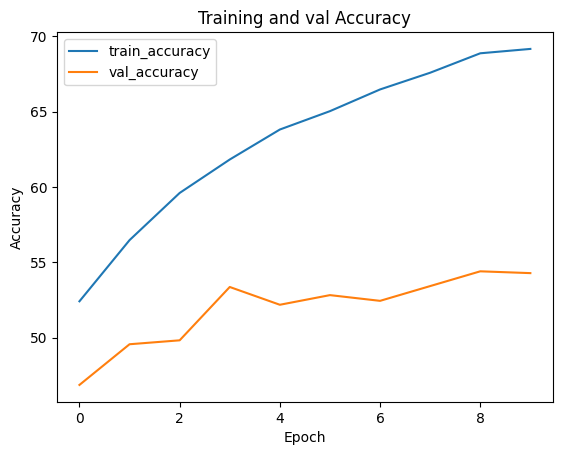

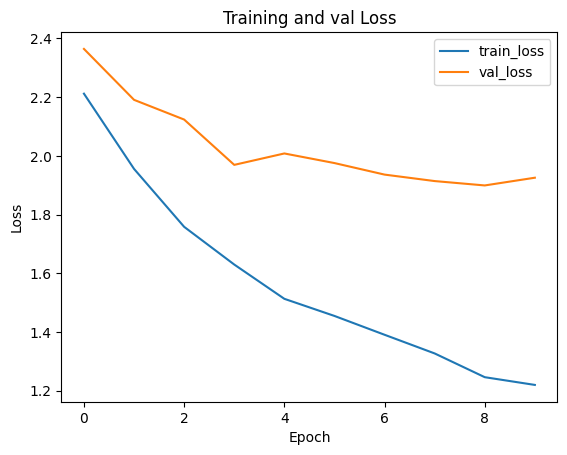

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_accuracy_list, label="train_accuracy")
plt.plot(val_accuracy_list, label="val_accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

In [ ]:
!gdown --id 1CTsseN_yFS-fSSmYHyYM536E3baxERvu
!unzip /content/Test.zip

In [23]:
import csv

test_folder = "/content/Test"
output_csv = "predictions.csv"

predictions = []

model.eval()

for image_name in os.listdir(test_folder):
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert('L')
    image = image.convert('RGB')

    image = val_transform(image)
    image = image.unsqueeze(0)  

    image = image.to(device)

    # Forward pass
    with torch.no_grad():
        output = model(image)

    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item() + 1  


    predictions.append([image_name, predicted_label])

with open(output_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["ImageName", "PredictedLabel"])
    writer.writerows(predictions)

print("Predictions saved to", output_csv)

Predictions saved to predictions.csv
